# COVID-19 대한민국 분석

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
# Statistical data visualization using matplotlib.
import seaborn as sns

# matplotlib: plotting with Python.
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Set the matplotlib color cycle using a seaborn palette.
sns.set_palette('pastel')

# plot outputs appear and be stored within the notebook.
%matplotlib inline

# A module for finding, managing, and using fonts across platforms.
mpl.font_manager._rebuild()
sorted([f.name for f in mpl.font_manager.fontManager.ttflist if f.name.startswith('Malgun')])

mpl.rc('axes', unicode_minus=False)

if sys.platform.startswith('darwin'):
    mpl.rc('font', family='AppleGothic')
elif sys.platform.startswith('win32'):
    mpl.rc('font', family='Malgun Gothic')

In [4]:
# An importlib package installable from any python version
import importlib
import modules.fs as fs
import modules.folium as fo

In [5]:
# 보건복지부_코로나19 시·도발생_현황
covid19_sido = fs.read_csv('./data/covid19_sido.csv')
covid19_sido.rename(columns={'시도명(한글)':'시도명'}, inplace=True)

covid19_sido['등록일시분초'] = pd.to_datetime(covid19_sido['등록일시분초'], format='%Y-%m-%d %H:%M:%S')
covid19_sido['등록일시'] = covid19_sido['등록일시분초'].dt.strftime('%Y-%m-%d')
covid19_sido['등록일시'] = pd.to_datetime(covid19_sido['등록일시'], format='%Y-%m-%d')

covid19_sido = covid19_sido[['등록일시', '시도명', '사망자 수', '확진자 수', '전일대비 증감 수', '격리 해제 수', '격리중 환자수', '지역발생 수', '해외유입 수', '10만명당 발생률']]

covid19_sido = covid19_sido[covid19_sido['시도명'] != '검역']
covid19_sido = covid19_sido[covid19_sido['시도명'] != '합계']

covid19_sido.drop_duplicates(subset=['시도명', '등록일시'], keep='last', inplace=True)
covid19_sido.index = np.arange(0, len(covid19_sido))
covid19_sido.head(1)

,등록일시,시도명,사망자 수,확진자 수,전일대비 증감 수,격리 해제 수,격리중 환자수,지역발생 수,해외유입 수,10만명당 발생률
0,2020-03-31,제주,0,9.0,0,3.0,NaN,NaN,NaN,1.34


In [6]:
# 보건복지부_코로나19 연령별·성별감염_현황
covid19_gen_age_case = fs.read_csv('./data/covid19_gen_age_case.csv')

covid19_gen_age_case.rename(columns={
    '구분(성별, 연령별)': '구분_성별_연령별'
}, inplace=True)

covid19_gen_age_case['등록일시분초'] = pd.to_datetime(covid19_gen_age_case['등록일시분초'], format='%Y-%m-%d %H:%M:%S')
covid19_gen_age_case['등록일시'] = covid19_gen_age_case['등록일시분초'].dt.strftime('%Y-%m-%d')
covid19_gen_age_case['등록일시'] = pd.to_datetime(covid19_gen_age_case['등록일시'], format='%Y-%m-%d')

covid19_gen_age_case = covid19_gen_age_case[['등록일시', '확진자', '확진률', '치명률', '사망자', '사망률', '구분_성별_연령별']]

covid19_gen_age_case.drop_duplicates(subset=['등록일시', '구분_성별_연령별'], keep='last', inplace=True)
covid19_gen_age_case.index = np.arange(0, len(covid19_gen_age_case))
covid19_gen_age_case.head(1)

,등록일시,확진자,확진률,치명률,사망자,사망률,구분_성별_연령별
0,2020-04-30,140,1.3,0.0,0,0.0,0-9


In [5]:
# 보건복지부_코로나19 감염_현황
covid19 = fs.read_csv( './data/covid19.csv')

covid19['등록일시분초'] = pd.to_datetime(covid19['등록일시분초'], format='%Y-%m-%d %H:%M:%S')
covid19['등록일시'] = covid19['등록일시분초'].dt.strftime('%Y-%m-%d')
covid19['등록일시'] = pd.to_datetime(covid19['등록일시'], format='%Y-%m-%d')

covid19 = covid19[['등록일시', '누적 환진률', '누적 검사 수', '누적 검사 완료 수', '치료중 환자 수', '격리해제 수', '사망자 수', '확진자 수', '검사진행 수', '결과 음성 수']]

covid19.drop_duplicates(subset=['등록일시'], keep='last', inplace=True)
covid19.index = np.arange(0, len(covid19))
covid19.head(1)

,등록일시,누적 환진률,누적 검사 수,누적 검사 완료 수,치료중 환자 수,격리해제 수,사망자 수,확진자 수,검사진행 수,결과 음성 수
0,2020-03-31,2.485826,410564.0,393672.0,4216.0,5408,162,9786,16892,383886.0


## 광역시도별 인구 데이터

In [7]:
population = fs.read_csv('./data/population_202010.csv')

code_by_sido = population.drop_duplicates(subset=['시도명', '시도코드'], keep='last')[['시도명', '시도코드']]
code_by_sido.index = np.arange(0, len(code_by_sido))

code_by_sido['시도명'].replace('특별시|광역시|특별자치시|특별자치도', '', regex=True, inplace=True)
code_by_sido['시도명'].replace('(경기|강원)도', r'\1', regex=True, inplace=True)
code_by_sido['시도명'].replace('(충|전|경)(?:청|라|상)(북|남)도', r'\1\2', regex=True, inplace=True)

sum_by_sido = population.groupby(['시도코드']).sum()[['인구수', '남자수', '여자수']]
mean_by_sido = population.groupby(['시도코드']).mean()[['시군구_x', '시군구_y']]

data_by_sido = pd.merge(sum_by_sido, mean_by_sido, on='시도코드', how='left')
pop_by_sido = pd.merge(code_by_sido, data_by_sido, on='시도코드', how='left')

pop_by_sido.head(1)

,시도명,시도코드,인구수,남자수,여자수,시군구_x,시군구_y
0,서울,11,9729107,4744059,4985048,954916.14522,1.950432e+06


## 보건복지부_코로나19 시·도발생\_현황

In [8]:
covid19_sido_pop = pd.merge(covid19_sido, pop_by_sido, on='시도명', how='left')

covid19_sido_pop['시도코드'] = covid19_sido_pop['시도코드'].astype('int64')
covid19_sido_pop['감염률'] = covid19_sido_pop['확진자 수'] / covid19_sido_pop['인구수'] * 100

covid19_sido_pop.index = np.arange(0, len(covid19_sido_pop))
covid19_sido_pop.to_csv('./data/covid19_sido_pop.csv', index=False)
covid19_sido_pop.head(1)

,등록일시,시도명,사망자 수,확진자 수,전일대비 증감 수,격리 해제 수,격리중 환자수,지역발생 수,해외유입 수,10만명당 발생률,시도코드,인구수,남자수,여자수,시군구_x,시군구_y,감염률
0,2020-03-31,제주,0,9.0,0,3.0,NaN,NaN,NaN,1.34,50,670989,337345,333644,909829.730366,1.488443e+06,0.001341


No handles with labels found to put in legend.


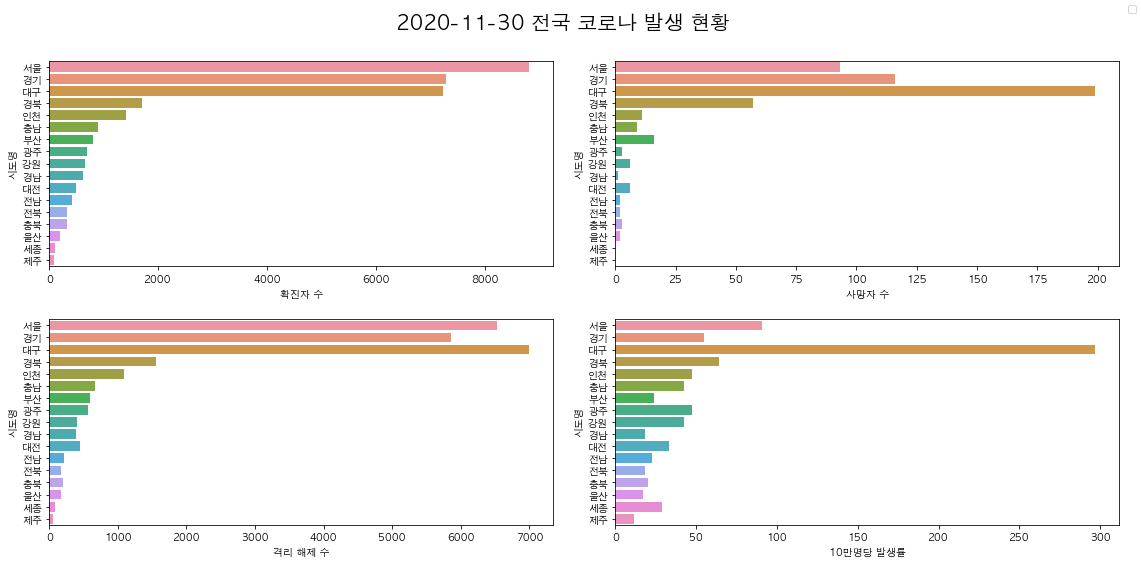

In [8]:
end_date = covid19_sido_pop.sort_values(by='등록일시', ascending=True)['등록일시'].iloc[-1].strftime('%Y-%m-%d')
plot_data = covid19_sido_pop.query("등록일시 in @end_date", engine='python').sort_values(by='확진자 수', ascending=False)

fig = plt.figure(figsize=(16,8))

ax = plt.subplot(2, 2, 1)
sns.barplot(data=plot_data,
    x='확진자 수', y='시도명'
)

ax = plt.subplot(2, 2, 2)
sns.barplot(data=plot_data,
    x='사망자 수', y='시도명'
)

ax = plt.subplot(2, 2, 3)
sns.barplot(data=plot_data,
    x='격리 해제 수', y='시도명'
)

ax = plt.subplot(2, 2, 4)
sns.barplot(data=plot_data,
    x='10만명당 발생률', y='시도명'
)

# 설정
fig.suptitle('{} 전국 코로나 발생 현황'.format(end_date), fontsize=20, fontweight='bold')
fig.legend()
fig.tight_layout(pad=2)

# 출력
plt.savefig('./assets/img/covid19_sido_pop.png', format='png', dpi=300)
plt.show()

## 보건복지부_코로나19 연령별·성별감염\_현황

In [9]:
covid19_gen_age_case.head(1)

,등록일시,확진자,확진률,치명률,사망자,사망률,구분_성별_연령별
0,2020-04-30,140,1.3,0.0,0,0.0,0-9


No handles with labels found to put in legend.


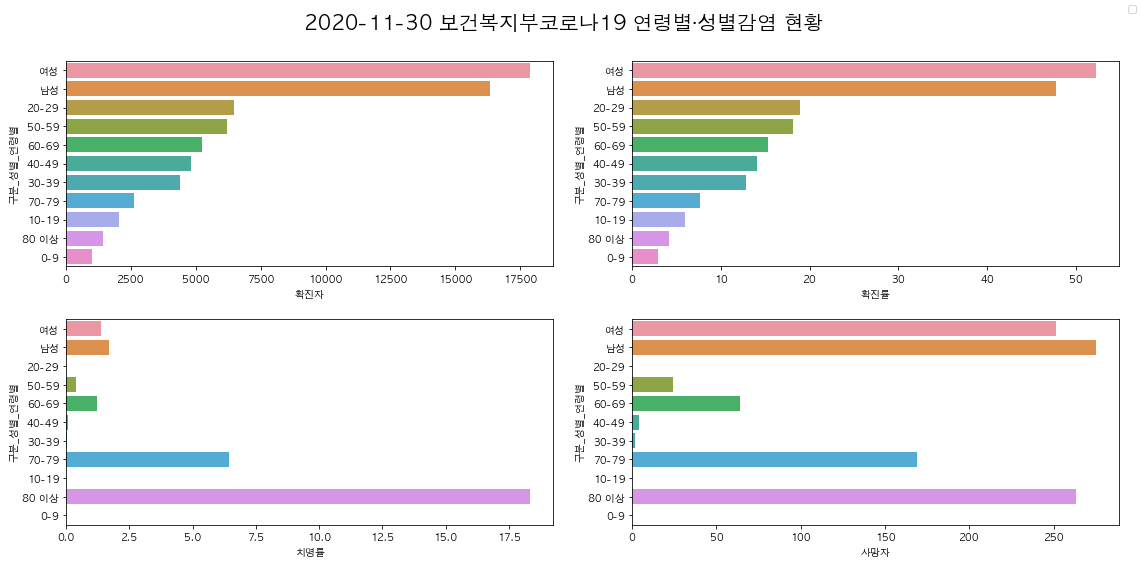

In [10]:
end_date = covid19_gen_age_case.sort_values(by='등록일시', ascending=True)['등록일시'].iloc[-1].strftime('%Y-%m-%d')
fig = plt.figure(figsize=(16,8))

ax = plt.subplot(2, 2, 1)
plot_data = covid19_gen_age_case.query("등록일시 in @end_date", engine='python').sort_values(by='확진자', ascending=False)
sns.barplot(data=plot_data,
    x='확진자', y='구분_성별_연령별',
)

ax = plt.subplot(2, 2, 2)
plot_data = covid19_gen_age_case.query("등록일시 in @end_date", engine='python').sort_values(by='확진자', ascending=False)
sns.barplot(data=plot_data,
    x='확진률', y='구분_성별_연령별',
)

ax = plt.subplot(2, 2, 3)
plot_data = covid19_gen_age_case.query("등록일시 in @end_date", engine='python').sort_values(by='확진자', ascending=False)
sns.barplot(data=plot_data,
    x='치명률', y='구분_성별_연령별',
)

ax = plt.subplot(2, 2, 4)
plot_data = covid19_gen_age_case.query("등록일시 in @end_date", engine='python').sort_values(by='확진자', ascending=False)
sns.barplot(data=plot_data,
    x='사망자', y='구분_성별_연령별',
)

# 설정
fig.suptitle('{} 보건복지부코로나19 연령별·성별감염 현황'.format(end_date), fontsize=20, fontweight='bold')
fig.legend()
fig.tight_layout(pad=2)

# 출력
plt.savefig('./assets/img/covid19_gen_age_case.png', format='png', dpi=300)
plt.show()

## 보건복지부_코로나19 감염\_현황

In [11]:
covid19.head(1)

,등록일시,누적 환진률,누적 검사 수,누적 검사 완료 수,치료중 환자 수,격리해제 수,사망자 수,확진자 수,검사진행 수,결과 음성 수
0,2020-03-31,2.485826,410564.0,393672.0,4216.0,5408,162,9786,16892,383886.0


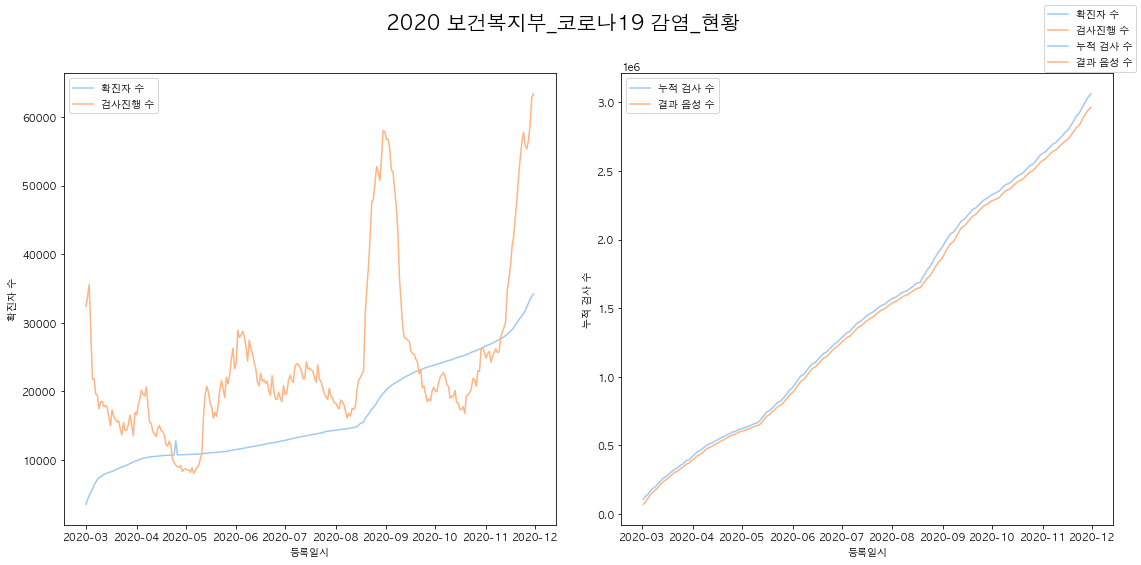

In [12]:
plot_data = covid19

fig = plt.figure(figsize=(16,8))

ax = plt.subplot(1, 2, 1)
sns.lineplot(data=plot_data,
    x='등록일시', y='확진자 수',
    label='확진자 수'
)
sns.lineplot(data=plot_data,
    x='등록일시', y='검사진행 수',
    label='검사진행 수'
)

ax = plt.subplot(1, 2, 2)
sns.lineplot(data=plot_data,
    x='등록일시', y='누적 검사 수',
    label='누적 검사 수'
)
sns.lineplot(data=plot_data,
    x='등록일시', y='결과 음성 수',
    label='결과 음성 수'
)

# 설정
fig.suptitle('2020 보건복지부_코로나19 감염_현황', fontsize=20, fontweight='bold')
fig.legend()
fig.tight_layout(pad=2)

# 출력
plt.savefig('./assets/img/covid19.png', format='png', dpi=300)
plt.show()